In [1]:
import sys
sys.path.append('../')
import adaprobe
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix
from sklearn.linear_model import Lasso
import os

In [2]:
os.listdir('../data')

['201119_cell2_A.npy',
 '201118_cell1_A.npy',
 '201121_cell1_A.npy',
 '201119_cell7_A.npy']

In [3]:
cell_names = os.listdir('../data/')

In [4]:
data_multicell = np.load('../data/%s'%cell_names[1], allow_pickle=True).item()

cell_locs, stimuli, responses, targets = data_multicell['cell_locs'], data_multicell['stimuli'], data_multicell['responses'], data_multicell['targets']
L = stimuli[:, :3]
I = stimuli[:, -1]
y = np.trapz(responses, axis=1)
N = len(cell_locs)

In [5]:
def find_common(arrs):
    """Recursive algorithm for finding common elements in a list of arrays.
    """
    if len(arrs) == 1:
        return arrs[0]
    elif len(arrs) == 2:
        return np.intersect1d(arrs[0], arrs[1])
    else:
        return np.intersect1d(arrs[0], find_common(arrs[1:]))

def find_reference(loc, reference, secondary=None):
    common = find_common([np.where(loc[i] == reference[:, i])[0] for i in range(len(loc))])
    if secondary is None:
        return common
    else:
        return np.intersect1d(common, secondary)
    
def find_stim_id(loc):
    return find_reference(loc, targets)

def lasso_map(power, alpha=1e-4):
    trial_locs = np.where(I == power)[0]
    cols = np.array([find_stim_id(L[trial_locs[i]]) for i in range(len(trial_locs))]).squeeze()
    rows = np.array(range(len(cols)))
    sparse_data = np.ones(len(cols))
    A = csc_matrix((sparse_data, (rows, cols)))
    
    sparse_lasso = Lasso(alpha=alpha, fit_intercept=False, max_iter=1000)
    sparse_lasso.fit(A, y[trial_locs])
    
    return sparse_lasso.coef_
    

In [6]:
alpha = 2e-4
lmap_50 = lasso_map(50, alpha=alpha)
lmap_70 = lasso_map(70, alpha=alpha)

In [7]:
fcoef = 2.5

In [8]:
depths = np.unique(L[:, -1])
ndepths = len(depths)
dim = 26

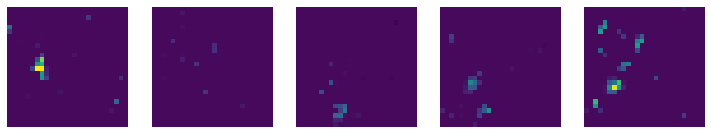

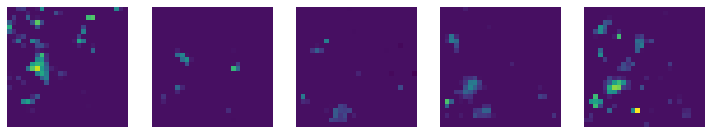

In [9]:
for lmap in [lmap_50, lmap_70]:

    plt.figure(figsize=(fcoef*ndepths, fcoef))
    vmin = np.min(lmap)
    vmax = np.max(lmap)
    for i, d in enumerate(depths):
        curr_plane = np.where(targets[:, -1] == d)[0]
        plt.subplot(1, ndepths, i + 1)
        plt.imshow(lmap[curr_plane].reshape([dim, dim]).T, cmap='viridis_r', vmin=vmin, vmax=vmax)
        plt.axis('off')
    plt.show()

In [10]:
priors = {
    'alpha': 0.5 * np.ones(N),
    'mu': np.zeros(N),
    'beta': 2e1 * np.ones(N),
    'shape': 1,
    'rate': 1,
    'phi_map': np.c_[1e-1 * np.ones(N), 1e1 * np.ones(N)],
    'phi_cov': np.array([np.array([[1e-1, 0], [0, 1e1]]) for _ in range(N)])
}

fit_options = {
    'iters': 50,
    'newton_steps': 20,
    'verbose': False,
    'num_mc_samples': 10,
    'init_t': 1e1,
    't_loops': 3,
    't_mult': 15
}

# init_t=1e4, t_mult=1e1, t_loops=10, iters=10, verbose=False, newton_steps=10, seed=None, num_mc_samples=5, return_parameter_history=False

In [11]:
model = adaprobe.Model(cell_locs, priors=priors, variational_model='omega-3d')

In [12]:
nsamples = len(y)

In [13]:
%time model.fit(y[:nsamples], (L[:nsamples], I[:nsamples]), method='cavi_offline_spike_and_slab_3d_omega', fit_options=fit_options)

CPU times: user 3min 53s, sys: 411 ms, total: 3min 54s
Wall time: 3min 54s


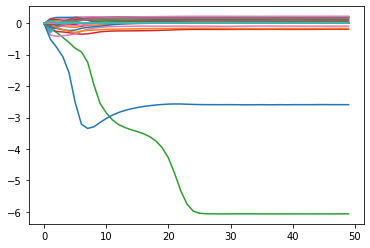

In [14]:
plt.plot(model.history['mu'])
plt.show()

In [15]:
model.state['mu']

array([ 2.82182948e-002,  7.17331771e-252, -6.06166825e+000,
       -1.91111108e-001,  1.86250576e-251, -1.11729396e-250,
       -9.41610110e-002,  6.47736808e-251,  1.58060043e-251,
        4.22749304e-250,  8.20980602e-251,  1.56997145e-001,
        9.76900983e-002,  4.52515316e-251,  1.74971327e-001,
        4.07345982e-251,  1.79968186e-001,  6.92290806e-251,
        2.34096530e-251,  7.72624230e-251,  1.77271022e-001,
        2.65439638e-251,  2.02758344e-001,  2.13908758e-251,
        9.50099825e-252,  1.27176365e-001,  4.54799550e-251,
        1.56828012e-001,  7.77035554e-252,  1.47445920e-251,
       -2.59049344e+000,  4.81708658e-251,  2.69498926e-251,
        2.03478407e-001, -1.00182580e-250,  3.20440874e-249,
        2.18435318e-001,  2.66001280e-251,  9.40348441e-251,
        4.92020546e-252,  3.25939489e-251, -1.66155847e-001,
        2.59858491e-251,  2.29139254e-251,  3.51013635e-251,
        6.50276378e-002,  2.89629388e-249,  1.57626047e-001,
        7.08619931e-251,

In [16]:
fontsize=12

In [17]:
mu = model.state['mu']
alpha = model.state['alpha']
beta = model.state['beta']
lam = np.array(model.state['lam']).T

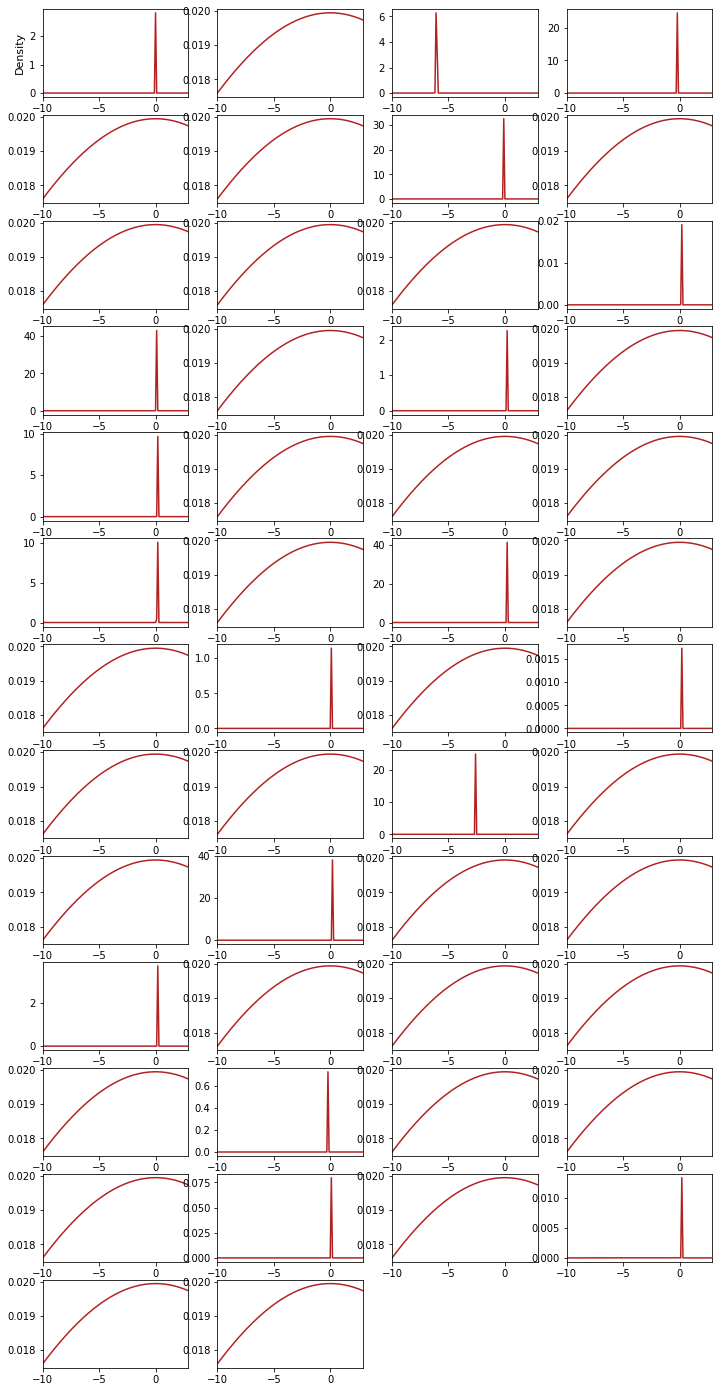

[0.892 0.5   1.    1.    0.5   0.5   1.    0.5   0.5   0.5   0.5   1.
 1.    0.5   1.    0.5   1.    0.5   0.5   0.5   1.    0.5   1.    0.5
 0.5   1.    0.5   1.    0.5   0.5   1.    0.5   0.5   1.    0.5   0.5
 1.    0.5   0.5   0.5   0.5   1.    0.5   0.5   0.5   1.    0.5   1.
 0.5   0.5  ]


In [18]:
xrange = np.arange(-10, 3, 0.1)
def gaussf(mean, sdev):
    return 1/(np.sqrt(2 * np.pi * sdev**2)) * np.exp(-1/(2 * sdev**2) * (xrange - mean)**2)

plt.figure(figsize=(12, 2*(N/4)))
for n in range(N):
    plt.subplot(int(np.ceil(N/4)), 4, n + 1)
    post = gaussf(mu[n], beta[n])
    plt.plot(xrange, post, color='firebrick')
    plt.xlim(np.min(xrange), np.max(xrange))
    if n == 0:
        plt.ylabel('Density', fontsize=fontsize-1)
plt.show()
# plt.savefig('figs/example_burnin_inference.png', format='png', bbox_inches='tight')

print(np.round(alpha, 3))

In [19]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

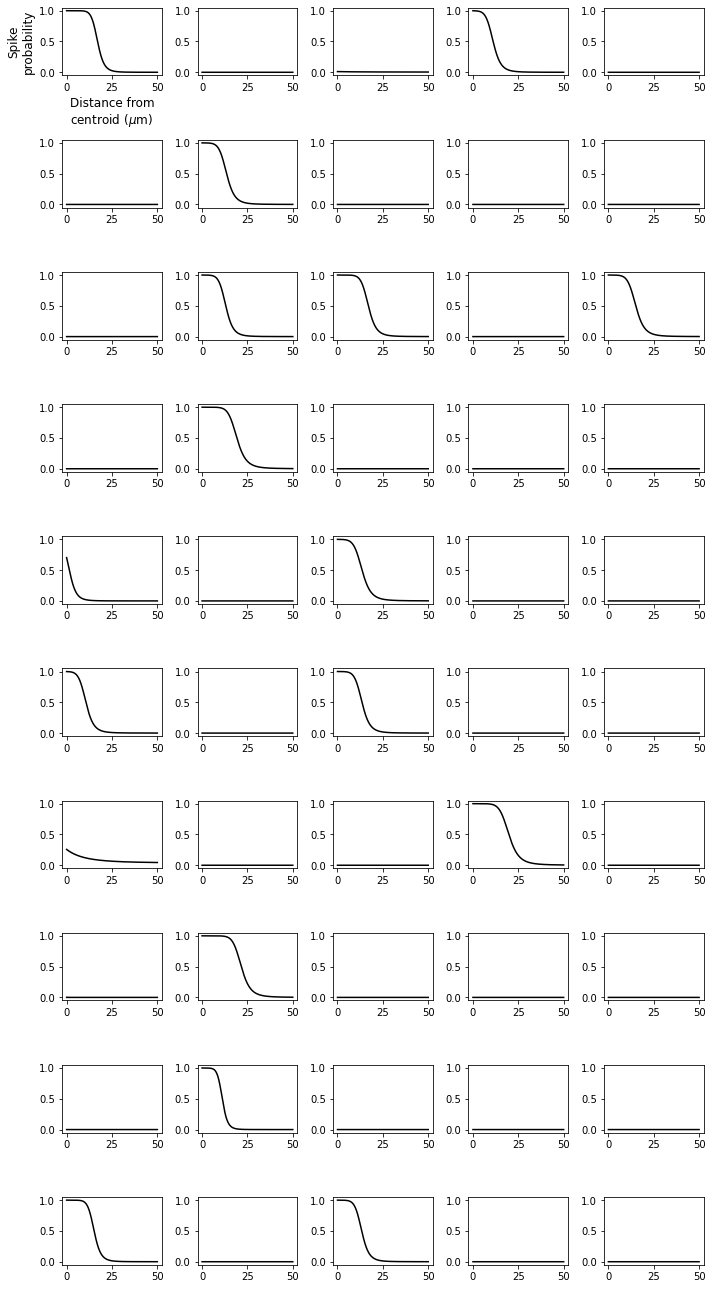

In [20]:
# for j in range(ensemble_size):
cntr = 1
power = 70
phi = model.state['phi_map']
cov = model.state['phi_cov']
phi_0_lower = [phi[i, 0] - np.sqrt(cov[i][0, 0]) for i in range(N)]
phi_0_upper = [phi[i, 0] + np.sqrt(cov[i][0, 0]) for i in range(N)]
phi_1_lower = [phi[i, 1] - np.sqrt(cov[i][1, 1]) for i in range(N)]
phi_1_upper = [phi[i, 1] + np.sqrt(cov[i][1, 1]) for i in range(N)]
omega = model.state['Omega']

plt.figure(figsize=(10, 18))
for i in range(N):
    # Set up receptive fields
    xran = np.arange(0, 50, 0.01)
    fn = sigmoid(phi[i, 0] * power * np.exp(-omega[i][0,0] * xran) - phi[i, 1])
    fn_lower = sigmoid(phi_0_lower[i] * power * np.exp(-omega[i][0,0] * xran) - phi_1_lower[i])
    fn_upper = sigmoid(phi_0_upper[i] * power * np.exp(-omega[i][0,0] * xran) - phi_1_upper[i])

    # Make plot
    plt.subplot(10, 5, cntr)
    plt.plot(xran, fn, 'k')
    plt.fill_between(xran, fn_lower, fn_upper, alpha=0.35, facecolor='firebrick', edgecolor='None')
    plt.ylim([-0.5e-1, 1 + 0.5e-1])
    plt.xticks([0, 25, 50])
    if cntr == 1:
        plt.ylabel('Spike\nprobability', fontsize=fontsize)
        plt.xlabel('Distance from\ncentroid ($\mu$m)', fontsize=fontsize)
    cntr += 1
plt.tight_layout()
plt.show()

In [21]:
spacing = 10
minx, maxx = np.min(cell_locs[:, 0]), np.max(cell_locs[:, 0])
miny, maxy = np.min(cell_locs[:, 1]), np.max(cell_locs[:, 1])
xr = np.arange(minx - spacing, maxx + spacing)
yr = np.arange(miny - spacing, maxy + spacing)
xgrid, ygrid = np.meshgrid(xr, yr)
grid = np.c_[xgrid.flatten(), ygrid.flatten()]

In [22]:
pred_maps_50 = {}
pred_maps_70 = {}
for d in depths:
    pred_maps_50[str(d)] = [
        adaprobe.experimental_design.posterior_predictive_map_on_plane_3d_omega(grid, d, 50, model, n_samples=100)
    ]
    pred_maps_70[str(d)] = [
        adaprobe.experimental_design.posterior_predictive_map_on_plane_3d_omega(grid, d, 70, model, n_samples=100)
    ]

In [23]:
fcoef = 3.5

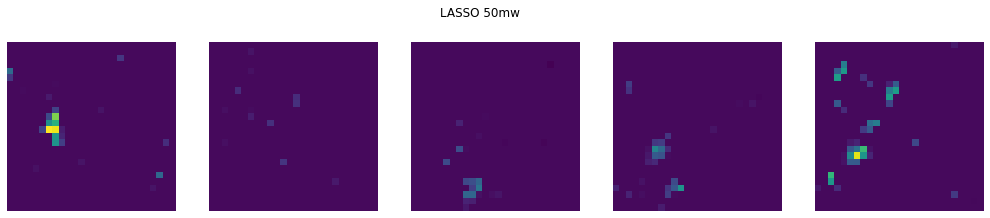

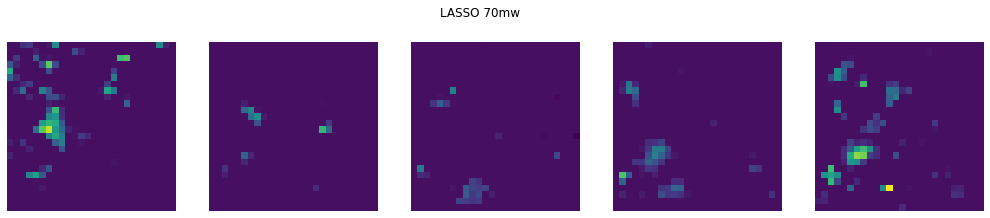

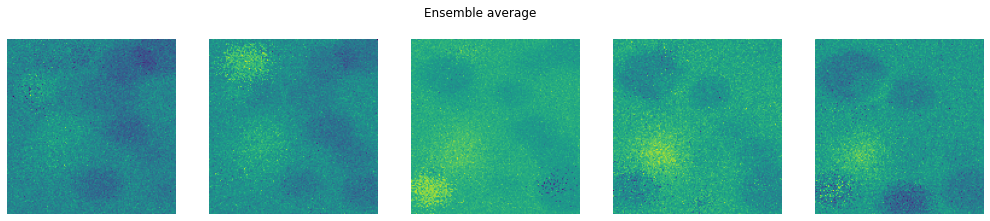

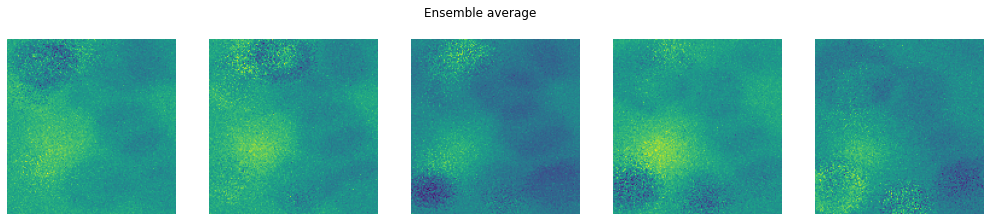

In [24]:
plt.figure(figsize=(fcoef*ndepths, fcoef))
plt.suptitle('LASSO 50mw')
vmin = np.min(lmap_50)
vmax = np.max(lmap_50)
for i, d in enumerate(depths):
    curr_plane = np.where(targets[:, -1] == d)[0]
    plt.subplot(1, ndepths, i + 1)
    plt.imshow(lmap_50[curr_plane].reshape([dim, dim]).T, cmap='viridis_r', vmin=vmin, vmax=vmax)
    plt.axis('off')
plt.show()

plt.figure(figsize=(fcoef*ndepths, fcoef))
plt.suptitle('LASSO 70mw')
vmin = np.min(lmap_70)
vmax = np.max(lmap_70)
for i, d in enumerate(depths):
    curr_plane = np.where(targets[:, -1] == d)[0]
    plt.subplot(1, ndepths, i + 1)
    plt.imshow(lmap_70[curr_plane].reshape([dim, dim]).T, cmap='viridis_r', vmin=vmin, vmax=vmax)
    plt.axis('off')
plt.show()

plt.figure(figsize=(fcoef*ndepths, fcoef))
plt.suptitle('Ensemble average')
for i, d in enumerate(depths):
    plt.subplot(1, ndepths, i + 1)
    plt.imshow(pred_maps_50[str(d)][0].reshape(len(yr), len(xr)), cmap='viridis_r')
    plt.axis('off')
plt.show()

plt.figure(figsize=(fcoef*ndepths, fcoef))
plt.suptitle('Ensemble average')
for i, d in enumerate(depths):
    plt.subplot(1, ndepths, i + 1)
    plt.imshow(pred_maps_70[str(d)][0].reshape(len(yr), len(xr)), cmap='viridis_r')
    plt.axis('off')
plt.show()

